이유한님의 커널 스터디입니다.  
https://www.youtube.com/watch?v=PUNyb6q5gDE&list=PLC_wC_PMBL5PexxXb6UC6pDXODE4xFWzL&index=4

In [120]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [121]:
import os
import gc # 메모리 챙길 때 씀
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings

In [122]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [123]:
pd.set_option('display.max_rows', 60)

In [124]:
pd.set_option('display.max_columns', 100)

데이터가 너무 커서 읽는데 시간이 너무 오래 걸립니다. 따라서 30000개만 읽어 디버깅을 해줘야 합니다.

In [125]:
debug = True

In [126]:
num_rows = 30000 if debug else None

df = get_train_test(DATA_DIRECTORY, num_rows = num_rows) # 함수 뜯어보기

In [127]:
# GENERAL CONFIGURATIONS
NUM_THRADS = 4
DATA_DIRECTORY = "../input/"
SUBMISSION_SUFIX = "_model2_04"

In [128]:
path = DATA_DIRECTORY
num_rows = num_rows

In [129]:
train_file_path = '../input/home-credit-default-risk/application_train.csv'
test_file_path = '../input/home-credit-default-risk/application_test.csv'

In [130]:
train = pd.read_csv(train_file_path, nrows = num_rows)
test = pd.read_csv(test_file_path, nrows = num_rows)

In [131]:
df = train.append(test)

In [132]:
train

In [133]:
df

In [134]:
del train, test

메모리를 주워담습니다.

In [135]:
gc.collect

## preprocessing

In [136]:
df = df[df['CODE_GENDER'] != 'XNA']# XNA에는 4명의 사람 밖에 없기 때문에 제거합니다.

In [137]:
df = df[df['AMT_INCOME_TOTAL'] < 20000000]# test의 Max income은 4백만, train은 1억7백만입니다.

In [138]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # 365243으로 기록된 사람들이 많습니다. 이는 의미 없는 숫자이므로 nan값을 적용하겠습니다.

In [139]:
df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

In [140]:
docs = [f for f in df.columns if 'FLAG_DOC' in f] # 이들은 binary data입니다. "에, 아니오" 등으로 이루어진 문서

In [141]:
df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

In [142]:
df[docs].sum(axis=1)

In [143]:
df[docs].kurtosis(axis=1).hist() # kurtosis는 분포의 꼬리를 의미합니다.

In [144]:
# 대출 심사가 통과됐는지 아닌지
docs

In [145]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [146]:
df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))
# get_age_label 함수의 df['DAYS_BIRTH']를 보면 -살아온 일 수가 기록돼 있음.
# 여기다 -를 취해 양수로 만들어준 이후 365로 나누면 나이가 나옴. 이를 구간으로 나눠준 함수

In [147]:
# EXT_SOURCE는 feature importance가 높게 나오는 값들입니다. 이들끼리 서로 interaction할 수 있게 곱해서 새로운 feature를 만들어줍니다.
df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# 현업에서는 설명이 되지 않는 변수는 사용하기 어렵지만 캐글에서는 점수를 높여야 하니 사용하는 경향이 있습니다.

In [148]:
# 경진대회에 참여하는 사람들이 해당 feature들 간의 상관관계를 조사해본 결과 2, 1, 3이 좋게 나타났습니다.
df['EXT_SOURCES_WEIGHTED'] = df.EXT_SOURCE_1 * 2 + df.EXT_SOURCE_2 * 1 + df.EXT_SOURCE_3 * 3

In [149]:
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

In [150]:
# eval 함수는 string 형태를 evaluation할 수 있도록 만들어줌

for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    df[feature_name] = eval('np.{}'.format(function_name))(
        df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [151]:
# Credit ratios
df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY'] # 연금을 받는데 빛은 얼마나 지는지
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE'] # 물건을 사는데 빚을 얼마나 지는지

In [152]:
# Income ratios
df['ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED'] # 일한 햇수에 비해 임금이 얼만지
df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

In [153]:
# Time ratios
df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] # 살아온 날 대비 얼마나 근로했는지
df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH'] # 회사에 아이디 만들어진지 얼마나 되는지
df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH'] # 나이 대비 car를 소유한 일 수
df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

Groupby: Statistics for applications in the same group

In [154]:
def do_mean(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].mean().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_median(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].median().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_std(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].std().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df


def do_sum(df, group_cols, counted, agg_name):
    gp = df[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(
        columns={counted: agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    gc.collect()
    return df

In [155]:
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'AGE_RANGE', 'CODE_GENDER']

In [156]:
df

In [157]:
df = do_median(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_MEDIAN')
df = do_std(df, group, 'EXT_SOURCES_MEAN', 'GROUP_EXT_SOURCES_STD')
df = do_mean(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_MEAN')
df = do_std(df, group, 'AMT_INCOME_TOTAL', 'GROUP_INCOME_STD')
df = do_mean(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_MEAN')
df = do_std(df, group, 'CREDIT_TO_ANNUITY_RATIO', 'GROUP_CREDIT_TO_ANNUITY_STD')
df = do_mean(df, group, 'AMT_CREDIT', 'CROUP_CREDIT_MEAN')
df = do_mean(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_MEAN')
df = do_std(df, group, 'AMT_ANNUITY', 'GROUP_ANNUITY_STD')

Encode categorical features (LabelEncoder)

In [158]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

In [159]:
def label_encoder(df, categorical_columns=None):
    """Encode categorical values as integers (0,1,2,3...) with pandas.factorize. """
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for col in categorical_columns:
        df[col], uniques = pd.factorize(df[col])
    return df, categorical_columns

In [160]:
df, le_encoded_cols = label_encoder(df, None)

In [161]:
def drop_application_columns(df):
    """ Drop features based on permutation feature importance. """
    drop_list = [
        'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
        'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'FLAG_PHONE',
        'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
        'REG_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
        'COMMONAREA_MODE', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'NONLIVINGAREA_AVG',
        'FLOORSMIN_MEDI', 'LANDAREA_MODE', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MODE',
        'FLOORSMIN_AVG', 'LANDAREA_AVG', 'FLOORSMIN_MODE', 'LANDAREA_MEDI',
        'COMMONAREA_MEDI', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG',
        'BASEMENTAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 
        'LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'ENTRANCES_MODE',
        'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'LIVINGAPARTMENTS_MEDI',
        'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_MEDI', 'LIVINGAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MODE', 'NONLIVINGAPARTMENTS_AVG', 'HOUSETYPE_MODE',
        'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE'
    ]
        
    # Drop most flag document columns
    for doc_num in [2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]:
        drop_list.append('FLAG_DOCUMENT_{}'.format(doc_num))
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [162]:
df = drop_application_columns(df)

breau는 당사가 아닌 다른 외부 대출 회사의 거래내역을 가져온 것입니다.

In [163]:
bureau_path = '../input/home-credit-default-risk/bureau.csv'
bureau = pd.read_csv(bureau_path, nrows=num_rows)

In [164]:
# Credit duration and credit/account end date difference
bureau['CREDIT_DURATION'] = bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']

# Credit to debt ratio and difference
bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

In [165]:
# One hot encoder
def one_hot_encoder(df, categorical_columns=None, nan_as_category=True):
    original_columns = list(df.columns)
    if not categorical_columns:
        categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # categorical_columns 만드는 과정 생략. 위에서 만든 자료 사용했음
    # dummy_na > nan 값을 dummies를 만들 때 포함할 것인지의 여부
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    categorical_columns = [c for c in df.columns if c not in original_columns]
    return df, categorical_columns

In [166]:
bureau, categorical_cols = one_hot_encoder(bureau, nan_as_category = False)

In [167]:
bureau_balance_path = '../input/home-credit-default-risk/bureau_balance.csv'
bb = pd.read_csv(bureau_balance_path, nrows=num_rows)

In [168]:
bb, categorical_cols = one_hot_encoder(bb, nan_as_category = False)

In [169]:
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [170]:
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [171]:
one_hot_encoder(bb, nan_as_category= False)

In [172]:
def get_bureau_balance(path, num_rows= None):
    bb = pd.read_csv(bureau_balance_path , nrows= num_rows)
    bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)
    # Calculate rate for each category with decay
    bb_processed = bb.groupby('SK_ID_BUREAU')[categorical_cols].mean().reset_index()
    # Min, Max, Count and mean duration of payments (months)
    agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_processed = group_and_merge(bb, bb_processed, '', agg, 'SK_ID_BUREAU')
    del bb; gc.collect()
    return bb_processed

In [173]:
 bureau = bureau.merge(get_bureau_balance(bureau_balance_path, num_rows), how='left', on='SK_ID_BUREAU')

In [174]:
bb = pd.read_csv(bureau_balance_path , nrows= num_rows)
bb, categorical_cols = one_hot_encoder(bb, nan_as_category= False)

In [175]:
bureau['STATUS_12345'] = 0

In [176]:
for i in range(1, 6):
    bureau['STATUS_12345'] += bureau['STATUS_{}'.format(i)]

Aggregate by number of months in balance and merge with bureau (loan length agg)

In [177]:
features = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM',
        'AMT_CREDIT_SUM_DEBT', 'DEBT_PERCENTAGE', 'DEBT_CREDIT_DIFF', 'STATUS_0', 'STATUS_12345']

In [178]:
agg_length = bureau.groupby('MONTHS_BALANCE_SIZE')[features].mean()

In [179]:
agg_length.rename({feat: 'LL_' + feat for feat in features}, axis=1, inplace=True)

In [180]:
bureau = bureau.merge(agg_length, how='left', on='MONTHS_BALANCE_SIZE')
del agg_length; gc.collect()

**General loans aggregations**  
bureau: (특정 주제에 대한 정보를 제공하는) 사무실[단체] > 본 은행 외에 다른 은행 등에서 빌린 돈에 관한 feature라고 생각할 수 있음.  
각 고객의 아이디를 기준으로 다양한 항목에 대한 min, max, mean, sum, var 등의 값을 얻을 수 있도록 데이터를 전처리 합니다.

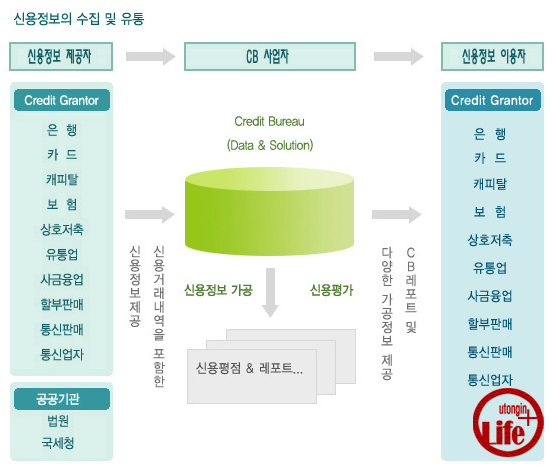

In [181]:
# AGGREGATIONS
# aggregation을 할 때 dictionary로 하면 편함

# bureau는 개인신용조회회사.
# bureau 데이터 셋에서 각각의 항목에 대한 최대, 최소, 평균 값 을 따져 보겠다는 것이다.
BUREAU_AGG = {
    'SK_ID_BUREAU': ['nunique'], # id가 몇개의 기관에 있는지
    'DAYS_CREDIT': ['min', 'max', 'mean'],  # 대출기간
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'DEBT_CREDIT_DIFF': ['mean', 'sum'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
    # Categorical
    'STATUS_0':['mean'],
    'STATUS_1':['mean'],
    'STATUS_12345': ['mean'],
    'STATUS_C': ['mean'],
    'STATUS_X': ['mean'],
    'CREDIT_ACTIVE_Active': ['mean'],
    'CREDIT_ACTIVE_Closed': ['mean'],
    'CREDIT_ACTIVE_Sold': ['mean'],
    'CREDIT_TYPE_Consumer credit': ['mean'],
    'CREDIT_TYPE_Credit card': ['mean'],
    'CREDIT_TYPE_Car loan': ['mean'],
    'CREDIT_TYPE_Mortgage': ['mean'],
    'CREDIT_TYPE_Microloan': ['mean'],
    # Group by loan duration features (months)
    'LL_AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'LL_DEBT_CREDIT_DIFF': ['mean'],
    'LL_STATUS_12345': ['mean'],
}

In [182]:
# e[0]: DAYS_CREDIT, e[1]: min >> {PREFIX}{DAYS_CREDIT}_{MIN}
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [183]:
# BUREAU_AGG 개수 만큼의 feature가 생성되는 것임.
agg_df = bureau.groupby('SK_ID_CURR').agg(BUREAU_AGG)
agg_df

In [184]:
agg_df.columns

In [185]:
bureau

In [186]:
# agg_bureau라는 dataframe을 생성. 앞으로 bureau에 관련해 생성한 agg feature는 여기다가 다 붙일 것임.
agg_bureau = group(bureau, 'BUREAU_', BUREAU_AGG)
agg_bureau

Active and closed loans aggregations

In [187]:
bureau['CREDIT_ACTIVE_Active'].value_counts()

In [188]:
bureau['DAYS_CREDIT']

In [189]:
# bureau['CREDIT_ACTIVE_Closed'][:10]
# bureau['CREDIT_ACTIVE_Active'][:10]
# 서로 반대로 나타남


BUREAU_ACTIVE_AGG = {
    'DAYS_CREDIT': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['min', 'mean'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'CREDIT_TO_ANNUITY_RATIO': ['mean'],
    'MONTHS_BALANCE_MEAN': ['mean', 'var'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
}

In [190]:
BUREAU_CLOSED_AGG = {
    'DAYS_CREDIT': ['max', 'var'],
    'DAYS_CREDIT_ENDDATE': ['max'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'sum'],
    'DAYS_CREDIT_UPDATE': ['max'],
    'ENDDATE_DIF': ['mean'],
    'STATUS_12345': ['mean'],
}

In [191]:
def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

In [192]:
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]

In [193]:
# agg_bureau는 붙일 df니까 신경 안써도 됨. active df를 BUREAU_ACTIVE_AGG에 관해 통계치를 얻어서 prefix 붙인 다음 이 각각에 대한 feature를 만들어 주는 작업임.
agg_bureau = group_and_merge(active, agg_bureau, 'BUREAU_ACTIVE_', BUREAU_ACTIVE_AGG)

In [194]:
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]

In [195]:
agg_bureau = group_and_merge(closed, agg_bureau, 'BUREAU_CLOSED_', BUREAU_CLOSED_AGG)

In [196]:
# 35개 추가
agg_bureau

In [197]:
del active, closed; gc.collect()

In [198]:
BUREAU_LOAN_TYPE_AGG = {
    'DAYS_CREDIT': ['mean', 'max'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'max'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'DAYS_CREDIT_ENDDATE': ['max'],
}

In [199]:
bureau

In [200]:
'Consumer credit'.split(' ')[0]

In [201]:
bureau[bureau['CREDIT_TYPE_' + 'Consumer credit'] == 1]

In [202]:
# BUREAU_CONSUMER_

for credit_type in ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan']:
    type_df = bureau[bureau['CREDIT_TYPE_' + credit_type] == 1]
    prefix = 'BUREAU_' + credit_type.split(' ')[0].upper() + '_'
    agg_bureau = group_and_merge(type_df, agg_bureau, prefix, BUREAU_LOAN_TYPE_AGG)
    del type_df; gc.collect()

In [203]:
# e[0]: DAYS_CREDIT, e[1]: min >> {PREFIX}{DAYS_CREDIT}_{MIN}
def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

In [204]:
agg_bureau.head()

Time based aggregations: last x months  
-180일, 6달 ~ 12개월 안의 데이터를 들여다 봅니다.

In [205]:
BUREAU_TIME_AGG = {
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'DEBT_PERCENTAGE': ['mean'],
    'DEBT_CREDIT_DIFF': ['mean'],
    'STATUS_0': ['mean'],
    'STATUS_12345': ['mean'],
}

In [206]:
for time_frame in [6, 12]:
    prefix = "BUREAU_LAST{}M_".format(time_frame)
    time_frame_df = bureau[bureau['DAYS_CREDIT'] >= -30*time_frame] # 현재를 기점으로 빌린지 얼마나 지났는지. 달 기준으로 체크 하겠다는 뜻
    agg_bureau = group_and_merge(time_frame_df, agg_bureau, prefix, BUREAU_TIME_AGG)
    del time_frame_df; gc.collect()

In [207]:
bureau[bureau['DAYS_CREDIT'] >= -30*6]

In [208]:
agg_bureau

last loan max overdue

In [209]:
sort_bureau = bureau.sort_values(by=['DAYS_CREDIT'])

In [210]:
# 연체가 된 것 중 가장 최근 것을 가져옴 (amount 기준)
gr = sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last().reset_index()

In [211]:
sort_bureau.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].last()

In [212]:
# 이름 바꿔줌
gr.rename({'AMT_CREDIT_MAX_OVERDUE': 'BUREAU_LAST_LOAN_MAX_OVERDUE'}, inplace=True)

In [213]:
agg_bureau = agg_bureau.merge(gr, on='SK_ID_CURR', how='left')

In [214]:
# Rations: total bebt/total credit and active loans debt/ active loans credit
agg_bureau['BUREAU_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_AMT_CREDIT_SUM_SUM']
agg_bureau['BUREAU_ACTIVE_DEBT_OVER_CREDIT'] = \
    agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']/agg_bureau['BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM']

# 전체를 다 합친 것에 빛이 얼마인지, 전체를 합친 것에 active debt(유동부채)가 얼마인지

In [215]:
agg_bureau

In [216]:
df.head()

In [217]:
# 여태까지 만들었던 agg_bureau를 df에 붙여줌
df = df.merge(agg_bureau, on='SK_ID_CURR', how='left')

In [218]:
df.head()

In [219]:
del agg_bureau

--------------------------- PREVIOUS PIPELINE -----------------------------

In [220]:
""" Process previous_application.csv and return a pandas dataframe. """

prev_path = '../input/home-credit-default-risk/previous_application.csv'
pay_path = '../input/home-credit-default-risk/installments_payments.csv'

prev = pd.read_csv(prev_path, nrows=num_rows)
pay = pd.read_csv(pay_path, nrows=num_rows)

In [221]:
prev.head()

In [222]:
ohe_columns = [
    'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'CHANNEL_TYPE',
    'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
    'NAME_PRODUCT_TYPE', 'NAME_CLIENT_TYPE']

In [223]:
prev, categorical_cols = one_hot_encoder(prev, ohe_columns, nan_as_category=False)

In [224]:
# Feature engineering rations and difference

prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']

In [225]:
total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']

In [226]:
# 총 이자 (공식을 적용함)
prev['SIMPLE_INTERESTS'] = (total_payment/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

In [227]:
# Actove loans = approved and not complete yet (last_due 365243)
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
active_df = approved[approved['DAYS_LAST_DUE'] == 365243]

In [228]:
# Find how much was already payed in active loans (using instalments csv)
# [pay['SK_ID_PREV']가 active_df['SK_ID_PREV']에 있는지, 있으면 Truw
active_pay = pay[pay['SK_ID_PREV'].isin(active_df['SK_ID_PREV'])]

active_pay_agg = active_pay.groupby('SK_ID_PREV')[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum()
active_pay_agg.reset_index(inplace=True)

In [229]:
# Active loans: difference of what was payed and instalments
active_pay_agg['INSTALMENT_PAYMENT_DIFF'] = active_pay_agg['AMT_INSTALMENT'] - active_pay_agg['AMT_PAYMENT']

In [230]:
# Merge with active_df
active_df = active_df.merge(active_pay_agg, on='SK_ID_PREV', how = 'left')
active_df['REMAINING_DEBT'] = active_df['AMT_CREDIT'] - active_df['AMT_PAYMENT']
active_df['REPAYMENT_RATIO'] = active_df['AMT_PAYMENT'] / active_df['AMT_CREDIT']

In [231]:
PREVIOUS_ACTIVE_AGG = {
    'SK_ID_PREV': ['nunique'],
    'SIMPLE_INTERESTS': ['mean'],
    'AMT_ANNUITY': ['max', 'sum'],
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['sum'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'AMT_PAYMENT': ['sum'],
    'INSTALMENT_PAYMENT_DIFF': ['mean', 'max'],
    'REMAINING_DEBT': ['max', 'mean', 'sum'],
    'REPAYMENT_RATIO': ['mean'],
}

In [232]:
# Perform aggregations for active applications
active_agg_df = group(active_df, 'PREV_ACTIVE_', PREVIOUS_ACTIVE_AGG)
active_df['TOTAL_REPAYMENT_RATIO'] = active_agg_df['PREV_ACTIVE_AMT_PAYMENT_SUM'] /\
                                     active_agg_df['PREV_ACTIVE_AMT_CREDIT_SUM']
del active_pay, active_pay_agg, active_df; gc.collect()

In [233]:
# Change 365.243 values to nan (missing)
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

In [234]:
# Days last due difference (scheduled x done) 기간이 얼마나 남았는지
prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
approved['DAYS_LAST_DUE_DIFF'] = approved['DAYS_LAST_DUE_1ST_VERSION'] - approved['DAYS_LAST_DUE']

In [235]:
# Categorical features
categorical_agg = {key: ['mean'] for key in categorical_cols}

In [236]:
PREVIOUS_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['max'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
    'DOWN_PAYMENT_TO_CREDIT': ['mean'],
}

In [237]:
# Perform general aggregations
# 두 딕셔너리를 합친 뒤 prefix 넣어서 그룹
agg_prev = group(prev, 'PREV_', {**PREVIOUS_AGG, **categorical_agg})

In [238]:
# Merge active loans dataframe on agg_prev
agg_prev = agg_prev.merge(active_agg_df, how='left', on='SK_ID_CURR')
del active_agg_df; gc.collect()

In [239]:
PREVIOUS_APPROVED_AGG = {
    'SK_ID_PREV': ['nunique'],
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['max'],
    'AMT_GOODS_PRICE': ['max'],
    'HOUR_APPR_PROCESS_START': ['min', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    'DAYS_TERMINATION': ['mean'],
    # Engineered features
    'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
    'APPLICATION_CREDIT_DIFF': ['max'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    # The following features are only for approved applications
    'DAYS_FIRST_DRAWING': ['max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['max', 'mean'],
    'DAYS_LAST_DUE_DIFF': ['min', 'max', 'mean'],
    'SIMPLE_INTERESTS': ['min', 'max', 'mean'],
}

In [240]:
PREVIOUS_REFUSED_AGG = {
    'AMT_APPLICATION': ['max', 'mean'],
    'AMT_CREDIT': ['min', 'max'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
    }

In [241]:
# Aggregations for approved and refused loans
agg_prev = group_and_merge(approved, agg_prev, 'APPROVED_', PREVIOUS_APPROVED_AGG)
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
agg_prev = group_and_merge(refused, agg_prev, 'REFUSED', PREVIOUS_REFUSED_AGG)
del approved, refused; gc.collect()

In [242]:
PREVIOUS_LOAN_TYPE_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['min', 'mean', 'max', 'var'],
    'APPLICATION_CREDIT_DIFF': ['min', 'var'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['max'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'mean'],
    'CNT_PAYMENT': ['mean'],
}

In [243]:
# Aggregation for Consumer loans and Cash loans
for loan_type in ['Consumer loans', 'Cash loans']:
    type_df = prev[prev['NAME_CONTRACT_TYPE_{}'.format(loan_type)] == 1]
    prefix = 'PREV_' + loan_type.split(" ")[0] + '_'
    agg_prev = group_and_merge(type_df, agg_prev, prefix, PREVIOUS_LOAN_TYPE_AGG)
    del type_df; gc.collect()

In [244]:
# Get the SK_ID_PREV for loans with late payments (days past due) 연체
pay['LATE_PAYMENT'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay['LATE_PAYMENT'] = pay['LATE_PAYMENT'].apply(lambda x: 1 if x > 0 else 0)
dpd_id = pay[pay['LATE_PAYMENT'] > 0]['SK_ID_PREV'].unique()

In [245]:
PREVIOUS_LATE_PAYMENTS_AGG = {
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

In [246]:
# Aggregations for loans with late payments
agg_dpd = group_and_merge(prev[prev['SK_ID_PREV'].isin(dpd_id)], agg_prev,
                         'PREV_LATE_', PREVIOUS_LATE_PAYMENTS_AGG)
del agg_dpd, dpd_id; gc.collect()

In [247]:
PREVIOUS_TIME_AGG = {
    'AMT_CREDIT': ['sum'],
    'AMT_ANNUITY': ['mean', 'max'],
    'SIMPLE_INTERESTS': ['mean', 'max'],
    'DAYS_DECISION': ['min', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    # Engineered features
    'APPLICATION_CREDIT_DIFF': ['min'],
    'APPLICATION_CREDIT_RATIO': ['min', 'max', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['mean'],
    'NAME_CONTRACT_TYPE_Cash loans': ['mean'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['mean'],
}

In [248]:
# Aggregations for loans in the last x months
# prev['DAYS_DECISION']: 대출이 이루어지기로 결정난 시점
for time_frame in [12, 24]:
    time_frame_df = prev[prev['DAYS_DECISION'] >= -30*time_frame] # 1년, 2년에 대해서 하겠다
    prefix = 'PREV_LAST{}M_'.format(time_frame)
    agg_prev = group_and_merge(time_frame_df, agg_prev, prefix, PREVIOUS_TIME_AGG)
    del time_frame_df; gc.collect()

In [249]:
agg_prev.head()

-------------------------POS-CASH-PIPELINE----------------------------

In [250]:
""" Process POS_CASH_balance.csv and return a pandas dataframe. """

In [251]:
pos_path = '../input/home-credit-default-risk/POS_CASH_balance.csv'
pos = pd.read_csv(pos_path, nrows=num_rows)
pos, categorical_cols = one_hot_encoder(pos, nan_as_category=False)

In [252]:
# Flag months with late payment
# 연체된 사람들
pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x:1 if x > 0 else 0)

In [253]:
POS_CASH_AGG = {
    'SK_ID_PREV': ['nunique'],
    'MONTHS_BALANCE': ['min', 'max', 'size'],
    'SK_DPD': ['max', 'mean', 'sum', 'var'],
    'SK_DPD_DEF': ['max', 'mean', 'sum'],
    'LATE_PAYMENT': ['mean']
}

In [254]:
# Aggregate by SH_ID_CURR
categorical_agg = {key: ['mean'] for key in categorical_cols}
pos_agg = group(pos, 'POS_', {**POS_CASH_AGG, **categorical_agg})

In [255]:
# Sort and group by SK_ID_PREV
sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
gp = sort_pos.groupby('SK_ID_PREV')
df = pd.DataFrame()
df['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
df['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()

In [256]:
# Percentage of previous loans completed and completed before initial term
# NAME_CONTRACT_STATUS: 당월 계약 현황 NAME_CONTRACT_STATUS_Completed: 할부가 끝났는지

df['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
# 기간의 첫 날과 마지막 날을 빼줌
df['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
# 두 개 이상의 column에 lambda를 적용하고 싶으면 데이터프레임에 바로 apply 붙이고 axis 주면 됨
df['POS_COMPLETED_BEFORE_MEAN'] = df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                          and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)

In [257]:
# Number of remaining installments (future installments) and percentage from total
# 전체 중 할부가 남은 수와 퍼센티지
df['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
df['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()

In [258]:
# Group by SK_ID_CURR and merge
df_gp = df.groupby('SK_ID_CURR').sum().reset_index()
df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace=True)
pos_agg = pd.merge(pos_agg, df_gp, on='SK_ID_CURR', how='left')
del df, gp, df_gp, sort_pos; gc.collect()

In [259]:
# Percentage of late payments for the 3 most recent applications
pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')

In [260]:
## 최근 3개의 balance 정보를 가져오고 싶은데 그렇게 하려면 groupby를 여러번 해야함.
# Last month of each applichation
# idxmax(): 최대값을 가지는 인덱스 레이블을 출력한다.
last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()

In [261]:
last_month_df

In [262]:
# Last month df > SK_ID_PREV1000011 이니까 -1은 가장 최근의 1달을 의미
for i, ele in pos.groupby('SK_ID_PREV')['MONTHS_BALANCE']:
    break

In [263]:
i

In [264]:
for i, ele in pos.groupby('SK_ID_PREV'):
    break

In [265]:
# 가장 최신의 것을 가져오고
ele['MONTHS_BALANCE']

In [266]:
# 가장 최신의 것의 인덱스를 뽑아냄
ele['MONTHS_BALANCE'].idxmax()

In [267]:
pos.iloc[29474]

In [268]:
# Most recent apllications (last 3)
# MONTHS_BALANCE: 신청일 대비 잔액월수
# sorting해서 마지막 달 3개 가져옴
sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR', 'LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

In [269]:
ele.reset_index()

In [270]:
# SK_ID_PREV로 내림차순 정렬, 만약 SK_ID_PREV 값이 같다면 MONTHS_BALANCE를 기준으로 내림차순
# ascending=[False, False] default
pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])